In [1]:
#From https://photutils.readthedocs.io/en/stable/epsf.html

#purpose is to take HST images, identify, and get resolution from point sources (stars)

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

3.8.5


In [2]:
#the goal of this cell is to refine object coordinates from some initial guesses using either 2MASS or GAIA

#taking star coords from text file
star_coords = np.genfromtxt('hh711_star_coords.txt', dtype=str)
print(star_coords)

#setting up query
result_table = []
for i in star_coords:
    ra, dec = i
    result_table.append(Simbad.query_region(SkyCoord(ra+dec, frame='icrs'), radius='0.05s'))
print(result_table)

[['03h29m02.8902198504s' '+31d16m00.953186124s']
 ['03h29m02.1578803464s' '+31d16m11.433429732s']
 ['3h29m03.7578170808s' '+31d16m03.947525688s']]
[<Table length=1>
MAIN_ID       RA           DEC      ...     COO_BIBCODE     SCRIPT_NUMBER_ID
           "h:m:s"       "d:m:s"    ...                                     
 object     str13         str13     ...        object            int32      
------- ------------- ------------- ... ------------------- ----------------
ASR   2 03 29 02.8902 +31 16 00.953 ... 2020yCat.1350....0G                1, <Table length=1>
MAIN_ID       RA           DEC      ...     COO_BIBCODE     SCRIPT_NUMBER_ID
           "h:m:s"       "d:m:s"    ...                                     
 object     str13         str13     ...        object            int32      
------- ------------- ------------- ... ------------------- ----------------
ASR   3 03 29 02.1578 +31 16 11.433 ... 2020yCat.1350....0G                1, <Table length=1>
  MAIN_ID         RA         

In [3]:
#next, we load in some HST images

# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #can edit this accordingly or edit your file names
    #using s.lower() includes uppercase extensions like FIT
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names

#the hubble images
path = 'hh7_11_checks/*'
files_data = [i.replace('\\', '/') for i in glob.glob(path)]
print(files_data)

#initializing some lists to be used
hdu_data_list = []
hdu_header_list = []

#opening data and headers
hdu_list = [fits.open(i) for i in files_data]

#I'm using count here just to point to specific indices that I've set up...unfortunately some have different headers...
#the only diff between the if and else cases are the indexing of the hdu's, some need 1 and some need 0
#I've tried to group it for convience, so the the first two have the same headers, the last 3 have the same headers
count = 0
for hdu_data in hdu_list:
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[0].data)
    hdu_header_list.append(hdu_data[0].header)

    count += 1

print('loaded data!')

['hh7_11_checks/hdu0_conv_656shifted_flam_0301_oIreproject2.fits', 'hh7_11_checks/hdu0_conv_656shifted_flam_656_hareproject_shifted_up5_left3.fits', 'hh7_11_checks/hdu0_conv_656shifted_flam_672_sIIreproject.fits', 'hh7_11_checks/hdu0_conv_656shifted_flam_background_corr_126_aligned.fits', 'hh7_11_checks/hdu0_conv_656shifted_flam_background_corr_128_aligned.fits', 'hh7_11_checks/hdu0_conv_656shifted_flam_background_corr_164_aligned.fits', 'hh7_11_checks/nonlin_656shifted_RFe2p6RH25p0start3400end400Tinc50fluxlim0p1e-17_f_Fe.fits', 'hh7_11_checks/nonlin_656shifted_RFe2p6RH25p0start3400end400Tinc50fluxlim0p1e-17_f_H.fits']
loaded data!


In [7]:
#follow https://photutils.readthedocs.io/en/stable/epsf.html

#now, locate spots on the images
from astropy.nddata import NDData
from astropy.table import Table
from astropy.wcs.utils import skycoord_to_pixel
from photutils.psf import extract_stars #use this to make star cutouts

# nddata = NDData(data=hdu_data_list[-1], wcs=WCS(hdu_header_list[-1]))   #here reformatting data from 1.64 micron HST image
nddata_list = [NDData(data=i, wcs=j) for i,j in zip(hdu_data_list, hdu_header_list) ]

#this was made complicated bc you cannot directly go from skycoord to Table
stars_list = []
for nddata in nddata_list:

    stars_tbl = Table(names=('x', 'y'))
    for i in range(len(result_table)):
        ra_dec_formatted = SkyCoord(result_table[i]['RA'][0] + ' ' + result_table[i]['DEC'][0], frame='icrs', unit=(u.hourangle, u.deg))
        pix = skycoord_to_pixel(ra_dec_formatted, WCS(hdu_header_list[i]))
        stars_tbl.add_row(pix)

    stars = extract_stars(nddata, stars_tbl, size=25) 
    stars_list.append(stars)

In [25]:
#finally, make psfs for each star and then we determine the resolution from the PSFs
#can be done by fitting a gaussian (or other kernel) and normalizing so integral of psf is 1

import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 1
ncols = 3

file_start = ['conv_0301_oIreproject2', 'conv_hareproject_shifted_up5_left3', 'conv_672_sIIreproject', 'conv_126_aligned', 'conv_128_aligned', 'conv_164_aligned.fits', 'f_Fe', 'f_H']

for i in range(len(stars_list)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    ax = ax.ravel()

    for j in range(nrows*ncols):
        norm = simple_norm(stars_list[i][j], 'log', percent=99.)
        ax[j].imshow(stars_list[i][j], norm=norm, origin='lower', cmap='viridis')
    
    plt.tight_layout()
    plt.savefig('hh7_11_checks/psfcutouts/'+file_start[i]+'_psfcutout.png')
    plt.close()

In [26]:
#attempting and failing to make an effective psf fitter

#increase maxiters to smooth more and decrease oversampling to avoid issues 
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=1, maxiters=30,
                           progress_bar=False)  

for i in range(len(stars_list)):
    epsf, fitted_stars = epsf_builder(stars_list[i])  
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.colorbar()
    plt.savefig('hh7_11_checks/EPSFs/'+file_start[i]+'_EPSF.png')
    plt.close()
    
        #https://photutils.readthedocs.io/en/stable/psf_matching.html could be inspiration
    #https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2016/WFC3-2016-12.pdf can see for more...

    #instead let's double check stackoverflow for now...seems complex
    #ultimately just trying epsf cross section, like in https://stackoverflow.com/questions/18920614/plot-cross-section-through-heat-map

    # Coordinates of the line we'd like to sample along
    line = [(0, 13.5), (25, 13.5)]

    # Convert the line to pixel/index coordinates
    x, y = np.arange(epsf.data.shape[0]), np.arange(epsf.data.shape[1])
    x_world, y_world = np.array(list(zip(*line)))
    col = epsf.data.shape[1] * (x_world - x.min()) / x.ptp()
    row = epsf.data.shape[0] * (y_world - y.min()) / y.ptp()

    # Interpolate the line at "num" points...
    num = 27
    row, col = [np.linspace(item[0], item[1], num) for item in [row, col]]

    # Plot...
    fig, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
    fig.delaxes(axes[0,1])

    axes[1,0].pcolormesh(x, y, epsf.data)
    axes[1,0].plot(x_world, y_world, 'ro-')
    axes[1,0].plot(y_world, x_world, 'bo-')
    axes[1,0].axis('image')

    # Extract the values along the line, using cubic interpolation
    import scipy as sp
    #horizontal cut
    cross_sec_hori = sp.ndimage.map_coordinates(epsf.data, np.vstack((row, col)))
    axes[0,0].scatter(np.arange(len(cross_sec_hori)), cross_sec_hori, color='r')

    #vertical cut
    cross_sec_vert = sp.ndimage.map_coordinates(epsf.data, np.vstack((col, row)))
    axes[1,1].scatter(cross_sec_vert, np.arange(len(cross_sec_vert)), color='b')

    plt.savefig('hh7_11_checks/psf_profiles/'+file_start[i]+'_EPSF.png')
    plt.close()

C:\Users\arubi\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
<ipython-input-26-2861d19fee47>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1,0].pcolormesh(x, y, epsf.data)
C:\Users\arubi\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
<ipython-input-26-2861d19fee47>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'

ValueError: Input position contains invalid values (NaNs or infs).

<ipython-input-53-d0b0bcfb0ba0>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1,0].pcolormesh(x, y, epsf.data)


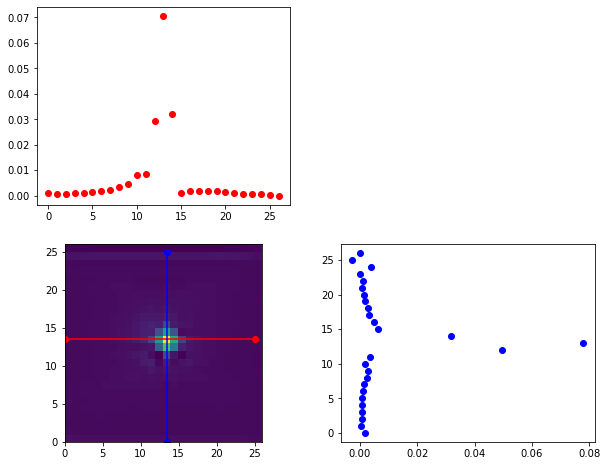

In [180]:
'''
This shows it is about 3 to 4 pixels wide for FWHM (haven't directly measured yet)

theta as in res is 1.2 * lambda / D
If we take 1.64 microns and 2.4e6 meters, then we get an angular res of 
1.319e-6 radians ?
Ok so we can use pixtorad of 6.217729758370198e-07 rads = 1 pix
So we therefore divide to get 2.12 pixels

So the 2.12 is perhaps a slight underestimate? Depends on the specifics of this model and the cross section, though
'''